## Libraries and Data Import

In [1]:
# Import Libraries
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Paired', color_codes=True)
import re

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
#Loading the data
df_train = pd.read_csv('../IOD_P1/train.csv')
df_test = pd.read_csv('../IOD_P1/test.csv')

In [3]:
#Check submission format
df_submit = pd.read_csv('../IOD_P1/sample_sub_reg.csv')

In [4]:
#First look at train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [5]:
#First look at test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [6]:
# Remove spaces from column headings via regular expression
df_train.columns = [re.sub(r'\s+', '', item) for item in df_train.columns]
df_test.columns = [re.sub(r'\s+', '', item) for item in df_test.columns]

## EDA

C:\Users\chani\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


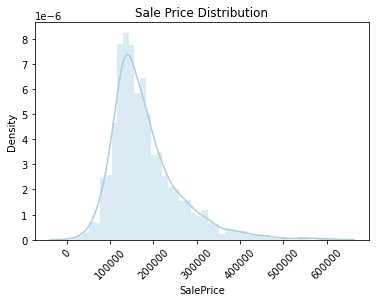

In [7]:
sns.distplot(df_train['SalePrice'])
plt.title('Sale Price Distribution')
plt.xticks(rotation=45);

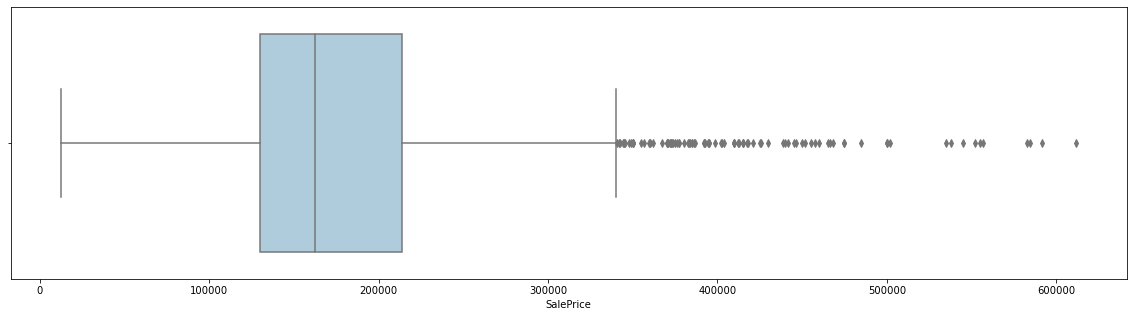

In [8]:
plt.figure(figsize=(20,5))
sns.boxplot(x=df_train['SalePrice'], data=df_train);

C:\Users\chani\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


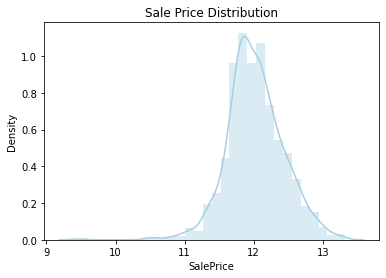

In [9]:
#If Log is applied to SalePrice, data would become more normally distributed; Will apply log when creating y for model creation
sns.distplot(np.log(df_train['SalePrice']), bins = 30)
plt.title('Sale Price Distribution');

### Explore Features

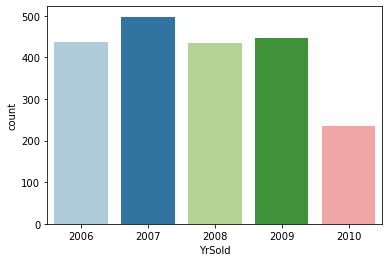

In [10]:
#check the distribution of year sold
sns.countplot(x=df_train['YrSold']);

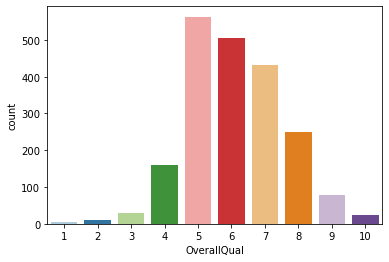

In [11]:
#check the distribution of overall quality
sns.countplot(x=df_train['OverallQual'], palette = 'Paired');

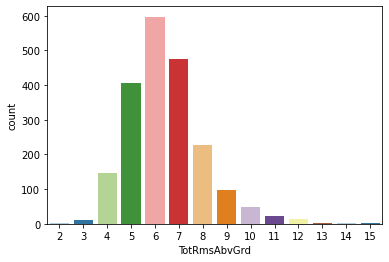

In [12]:
##check the distribution of total rooms above ground
sns.countplot(x=df_train['TotRmsAbvGrd'], palette = 'Paired');

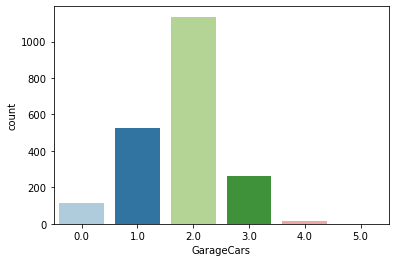

In [13]:
#check the distribution of garage size(by no. of cars)
sns.countplot(x=df_train['GarageCars']);

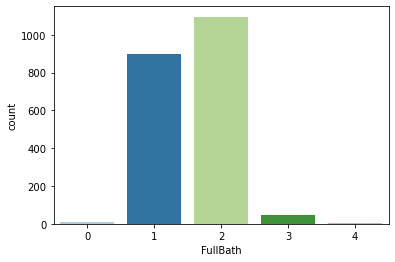

In [14]:
#check the distribution of no. of full bathrooms
sns.countplot(x=df_train['FullBath']);

### Explore distribution of features with strong correlation

In [15]:
#Find correlation amoung numeric features
corr = df_train.corr()

In [16]:
#Check top positive-correlation with SalePrice
corr['SalePrice'].sort_values(ascending=False).head(11)

SalePrice        1.000000
OverallQual      0.800207
GrLivArea        0.697038
GarageArea       0.650270
GarageCars       0.648220
TotalBsmtSF      0.628925
1stFlrSF         0.618486
YearBuilt        0.571849
YearRemod/Add    0.550370
FullBath         0.537969
GarageYrBlt      0.533922
Name: SalePrice, dtype: float64

In [17]:
#Check whether there is any strong negative correlation with SalePrice; does not seem to be the case.
corr['SalePrice'].sort_values(ascending=False).tail(10)

MiscVal         -0.007375
YrSold          -0.015203
LowQualFinSF    -0.041594
BsmtHalfBath    -0.045328
Id              -0.051398
MSSubClass      -0.087335
OverallCond     -0.097019
KitchenAbvGr    -0.125444
EnclosedPorch   -0.135656
PID             -0.255052
Name: SalePrice, dtype: float64

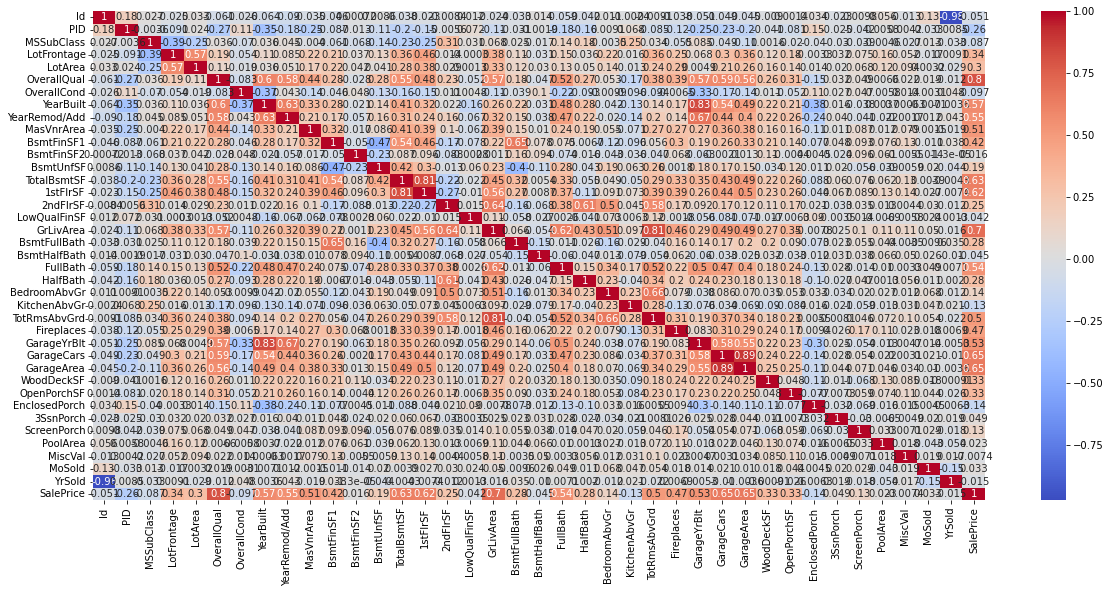

In [18]:
#Craete heatmap for all numerical features
plt.figure(figsize = (20, 9))
sns.heatmap(df_train.corr(),annot_kws={'size': 10}, annot=True, cmap='coolwarm');

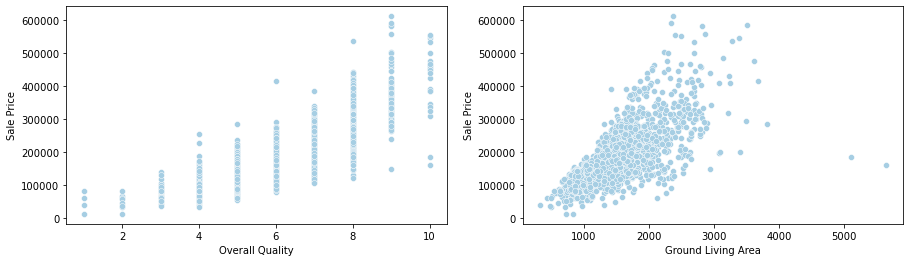

In [19]:
#Scatter plots of features with high corelation to sale price 
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
sns.scatterplot(x='OverallQual', y='SalePrice', data=df_train)
plt.xlabel('Overall Quality'); plt.ylabel('Sale Price')
plt.subplot(1,2,2)
sns.scatterplot(x='GrLivArea', y='SalePrice', data = df_train)
plt.xlabel('Ground Living Area'); plt.ylabel('Sale Price');

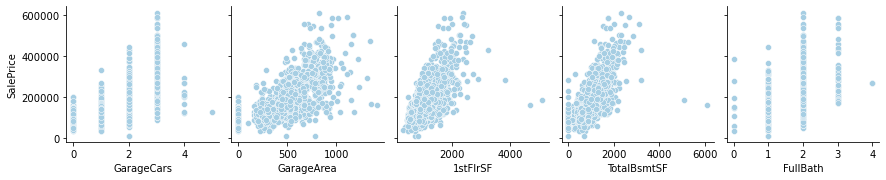

In [20]:
#Scatter plots of features with high corelation to sale price 
var = ['GarageCars','GarageArea','1stFlrSF','TotalBsmtSF','FullBath']
sns.pairplot(x_vars = var, y_vars = 'SalePrice', data = df_train);

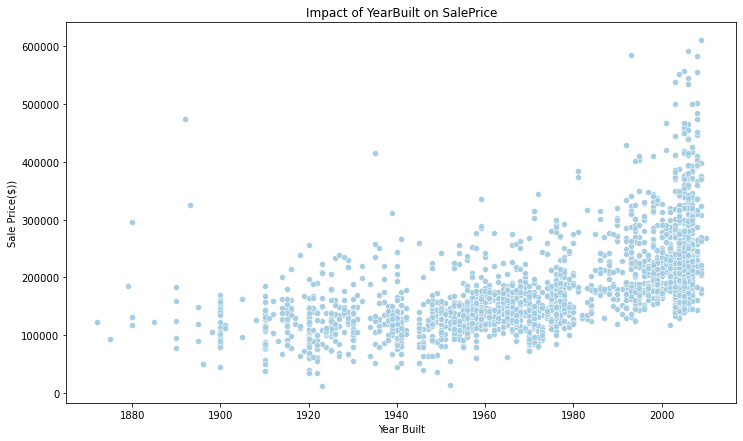

In [21]:
#Scatter plot between year built and sale price 
plt.figure(figsize=(12,7))
sns.scatterplot(x='YearBuilt', y='SalePrice' ,data=df_train)
plt.xlabel('Year Built')
plt.ylabel('Sale Price($))')
plt.title('Impact of YearBuilt on SalePrice');

## Data Processing

### Find NA

In [22]:
#Plot missing value count
def plot_null_count(df):
    name =[x for x in globals() if globals()[x] is df][0]
    null_count = df.isnull().sum().sort_values(ascending = False).reset_index()
    null_count = null_count[null_count[0] > 0]
    null_count.T
    plt.figure(figsize = (20, 7))
    plt.title('Missing Values in Each Column from: %s' %name)
    chart = sns.barplot(x = 'index', y = 0, data=null_count, palette='coolwarm')
    plt.xticks(rotation=45)
    plt.xlabel('Column')
    plt.ylabel('Count')
    chart.bar_label(chart.containers[0]);
    return null_count.T

In [23]:
#Plot missing value ratio
def plot_null_ratio(df):
    name =[x for x in globals() if globals()[x] is df][0]
    null_count = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending = False).reset_index()
    null_count = null_count[null_count[0] > 0]
    plt.figure(figsize = (20, 7))
    plt.title('Missing Values Ratio in Each Column from: %s' %name)
    chart = sns.barplot(x = 'index', y = 0, data=null_count, palette='coolwarm')
    plt.xticks(rotation=45)
    plt.xlabel('Column')
    plt.ylabel('Count')
    chart.bar_label(chart.containers[0]);
    return null_count.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
index,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageFinish,GarageQual,GarageYrBlt,GarageCond,GarageType,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrArea,MasVnrType,BsmtHalfBath,BsmtFullBath,GarageArea,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinSF1,GarageCars
0,2042,1986,1911,1651,1000,330,114,114,114,114,113,58,56,55,55,55,22,22,2,2,1,1,1,1,1,1


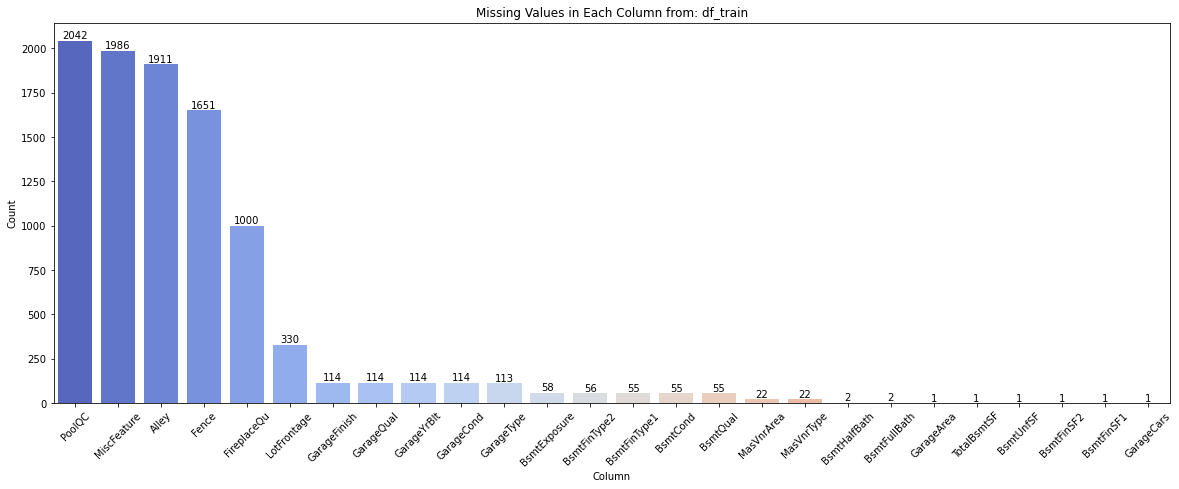

In [24]:
plot_null_count(df_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
index,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageFinish,GarageQual,GarageYrBlt,GarageCond,GarageType,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrArea,MasVnrType,BsmtHalfBath,BsmtFullBath,GarageArea,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinSF1,GarageCars
0,99.56119,96.830814,93.174061,80.497318,48.756704,16.089712,5.558264,5.558264,5.558264,5.558264,5.509508,2.827889,2.730375,2.681619,2.681619,2.681619,1.072647,1.072647,0.097513,0.097513,0.048757,0.048757,0.048757,0.048757,0.048757,0.048757


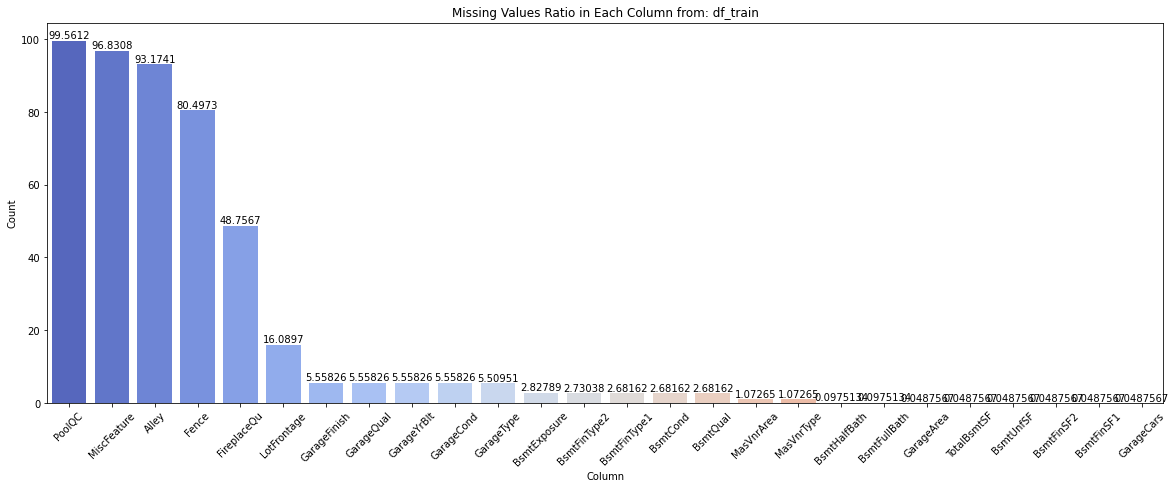

In [25]:
plot_null_ratio(df_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
index,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageYrBlt,GarageFinish,GarageQual,GarageCond,GarageType,BsmtFinType1,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType2,Electrical,MasVnrType,MasVnrArea
0,874,837,820,706,422,160,45,45,45,45,44,25,25,25,25,25,1,1,1


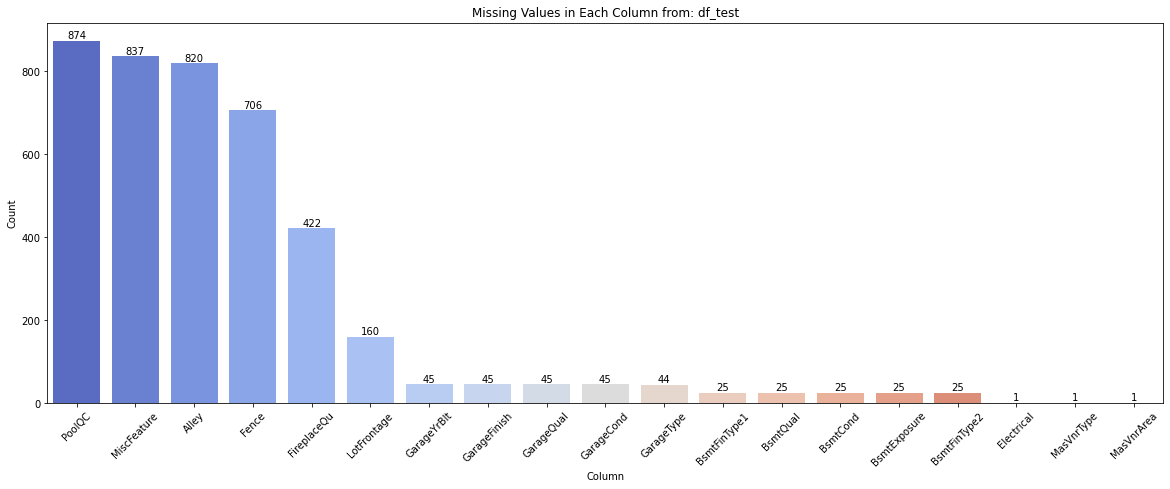

In [26]:
plot_null_count(df_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
index,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageYrBlt,GarageFinish,GarageQual,GarageCond,GarageType,BsmtFinType1,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType2,Electrical,MasVnrType,MasVnrArea
0,99.544419,95.330296,93.394077,80.410023,48.063781,18.223235,5.125285,5.125285,5.125285,5.125285,5.01139,2.84738,2.84738,2.84738,2.84738,2.84738,0.113895,0.113895,0.113895


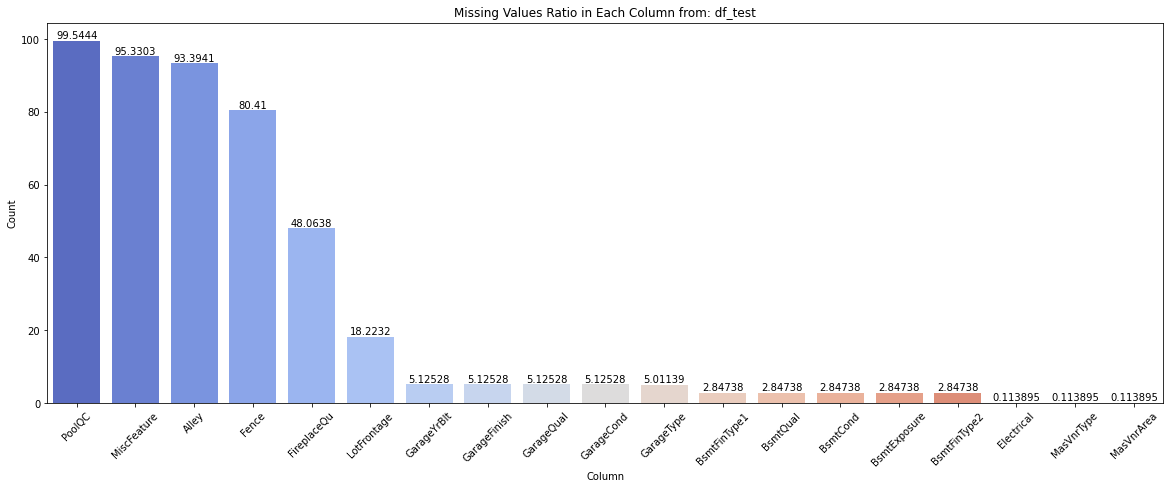

In [27]:
plot_null_ratio(df_test)

## Fill NA for train data

In [28]:
#Drop columns that have more than 90% NA
df_train.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

In [29]:
df_train['PoolArea'].value_counts() #Most are '0', later can drop this feature

0      2042
519       1
576       1
800       1
228       1
480       1
648       1
738       1
368       1
561       1
Name: PoolArea, dtype: int64

In [30]:
df_train['MiscVal'].value_counts() #Most are '0', later can drop this feature

0        1986
400        12
500         8
600         6
450         5
2000        5
700         4
1200        2
3000        2
2500        2
4500        2
17000       1
1300        1
900         1
1500        1
800         1
6500        1
54          1
3500        1
1150        1
300         1
455         1
8300        1
460         1
12500       1
480         1
650         1
80          1
Name: MiscVal, dtype: int64

In [31]:
#Fill NA for Fence & FireplaceQu
df_train['Fence'].fillna('NA', inplace=True)
df_train['FireplaceQu'].fillna(value='NA', inplace=True)

In [32]:
df_train['LotFrontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

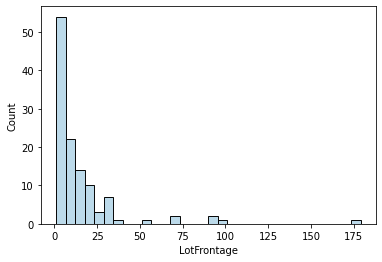

In [33]:
#Check LotFrontage distribution
sns.histplot(data=df_train, x=df_train['LotFrontage'].value_counts());

In [34]:
#Use median to fill NA
df_train['LotFrontage'].fillna(value=df_train['LotFrontage'].median(), inplace=True)

In [35]:
# Fill missing for garage features; Using YearBuilt for missing GarageYrBlt
df_train = df_train.fillna({
    'GarageYrBlt': df_train['YearBuilt'],
    'GarageFinish': 'NA',
    'GarageQual': 'NA',
    'GarageCond': 'NA',
    'GarageType': 'NA'
})

In [36]:
#Drop rows with NA that are around 5% or less
to_drop = ['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual',
           'MasVnrArea','MasVnrType','BsmtHalfBath','BsmtFullBath','GarageArea','TotalBsmtSF',
           'BsmtUnfSF','BsmtFinSF2','BsmtFinSF1','GarageCars']
df_train.dropna(subset=to_drop, inplace=True)


## Fill NA for test data

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2050
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1969 non-null   int64  
 1   PID            1969 non-null   int64  
 2   MSSubClass     1969 non-null   int64  
 3   MSZoning       1969 non-null   object 
 4   LotFrontage    1969 non-null   float64
 5   LotArea        1969 non-null   int64  
 6   Street         1969 non-null   object 
 7   LotShape       1969 non-null   object 
 8   LandContour    1969 non-null   object 
 9   Utilities      1969 non-null   object 
 10  LotConfig      1969 non-null   object 
 11  LandSlope      1969 non-null   object 
 12  Neighborhood   1969 non-null   object 
 13  Condition1     1969 non-null   object 
 14  Condition2     1969 non-null   object 
 15  BldgType       1969 non-null   object 
 16  HouseStyle     1969 non-null   object 
 17  OverallQual    1969 non-null   int64  
 18  OverallC

In [38]:
#Drop columns that have more than 90% NA
df_test.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

In [39]:
#Fill NA for Fence & FireplaceQu
df_test['Fence'].fillna('NA', inplace=True)
df_test['FireplaceQu'].fillna(value='NA', inplace=True)

In [40]:
df_test['LotFrontage'].describe()

count    718.000000
mean      69.545961
std       23.533945
min       21.000000
25%       59.000000
50%       68.000000
75%       80.000000
max      182.000000
Name: LotFrontage, dtype: float64

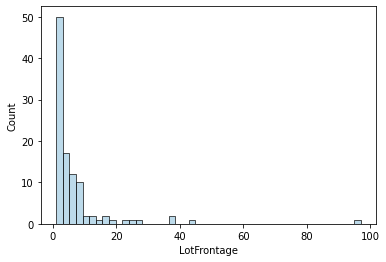

In [41]:
#Check LotFrontage distribution
sns.histplot(data=df_test, x=df_test['LotFrontage'].value_counts());

In [42]:
#Use median to fill NA
df_test['LotFrontage'].fillna(value=df_test['LotFrontage'].median(), inplace=True)

In [43]:
# Fill missing for garage features
df_test = df_test.fillna({
    'GarageYrBlt': df_test['YearBuilt'],
    'GarageFinish': 'NA',
    'GarageQual': 'NA',
    'GarageCond': 'NA',
    'GarageType': 'NA'
})

In [44]:
# Fill missing for basement features
df_test = df_test.fillna({
    'BsmtQual': 'NA',
    'BsmtCond': 'NA',
    'BsmtExposure': 'NA',
    'BsmtFinType1': 'NA',
    'BsmtFinType2': 'NA',
    'BsmtFinSF1': 0,
    'BsmtFinSF2': 0,
    'BsmtUnfSF': 0,
    'TotalBsmtSF': 0,
    'BsmtFullBath': 0,
    'BsmtHalfBath': 0
})

In [45]:
df_test['Electrical'].value_counts()

SBrkr    813
FuseA     48
FuseF     15
FuseP      1
Name: Electrical, dtype: int64

In [46]:
#Fill NA for df_test['Electrical'] with mode, which is SBrkr
df_test['Electrical'].fillna('SBrkr', inplace = True)

In [47]:
df_test['MasVnrType'].value_counts()

None       534
BrkFace    250
Stone       80
BrkCmn      12
CBlock       1
Name: MasVnrType, dtype: int64

In [48]:
#Fill NA for df_test['MasVnrType'] with mode, which is None
df_test['MasVnrType'].fillna('None', inplace = True)

In [49]:
#Fill NA for df_test['MasVnrArea'] with mean
df_test['MasVnrArea'].fillna(df_test['MasVnrArea'].mean(), inplace = True)

### Features Engineering

In [50]:
#Get categorical features
nonnumeric_features = df_train.select_dtypes(include=['object'])
nonnumeric_features.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'SaleType'],
      dtype='object')

In [51]:
#Examine unique values of non numeric features
for f in nonnumeric_features.columns:
    print(f, nonnumeric_features[f].unique())

MSZoning ['RL' 'RM' 'FV' 'C (all)' 'RH']
Street ['Pave' 'Grvl']
LotShape ['IR1' 'Reg' 'IR2' 'IR3']
LandContour ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities ['AllPub' 'NoSeWa']
LotConfig ['CulDSac' 'Inside' 'Corner' 'FR2' 'FR3']
LandSlope ['Gtl' 'Sev' 'Mod']
Neighborhood ['Sawyer' 'SawyerW' 'NAmes' 'Timber' 'Edwards' 'OldTown' 'BrDale'
 'CollgCr' 'Somerst' 'Mitchel' 'StoneBr' 'Gilbert' 'Crawfor' 'IDOTRR'
 'NWAmes' 'Veenker' 'MeadowV' 'NridgHt' 'SWISU' 'NoRidge' 'ClearCr'
 'Blmngtn' 'BrkSide' 'NPkVill' 'Blueste' 'GrnHill' 'Greens' 'Landmrk']
Condition1 ['RRAe' 'Norm' 'PosA' 'Artery' 'Feedr' 'PosN' 'RRAn' 'RRNe' 'RRNn']
Condition2 ['Norm' 'RRNn' 'Feedr' 'Artery' 'PosA' 'PosN' 'RRAe' 'RRAn']
BldgType ['1Fam' 'TwnhsE' 'Twnhs' '2fmCon' 'Duplex']
HouseStyle ['2Story' '1Story' '1.5Fin' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin' '1.5Unf']
RoofStyle ['Gable' 'Hip' 'Flat' 'Mansard' 'Shed' 'Gambrel']
RoofMatl ['CompShg' 'WdShngl' 'Tar&Grv' 'WdShake' 'Membran' 'ClyTile']
Exterior1st ['HdBoard' 'VinylSd' 'Wd Sdng' 'B

In [52]:
#Combine data for transformation
df_train['Train_Test'] = 'Train'
df_test['Train_Test'] = 'Test'
df_test['SalePrice'] = np.nan
df_combined = pd.concat([df_train, df_test])

In [53]:
#Transform categorical features to scale 0 to 7
scale = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
df_combined['Functional'] = df_combined['Functional'].map(scale)

In [54]:
#Transform categorical features to scale 0 to 5
scale = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
for feat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual','GarageQual', 'GarageCond']:
    df_combined[feat] = df_combined[feat].map(scale)

In [55]:
#Transform categorical features to scale 0 to 1
scale = {'N':0, 'Y':1}
df_combined['CentralAir'] = df_combined['CentralAir'].map(scale)

In [56]:
#Transform categorical features to scale 0 to 2
scale = {'N':0, 'Y':2 , 'P':1}
df_combined['PavedDrive'] = df_combined['PavedDrive'].map(scale)

In [57]:
#Transform categorical features to scale 0 to 2
scale = {'Gtl':0 ,'Mod':1 , 'Sev':2}
df_combined['LandSlope'] = df_combined['LandSlope'].map(scale) 

In [58]:
#Transform categorical features to scale 0 to 3
scale = {'Reg':0 ,'IR1':1 , 'IR2':2, 'IR3':3}
df_combined['LotShape'] = df_combined['LotShape'].map(scale) 

In [59]:
#Create new feature to combine all bathrooms
df_combined['Total_Bath'] = df_combined['BsmtFullBath']+df_combined['FullBath']+0.5*(df_combined['BsmtHalfBath']+df_combined['HalfBath'])

In [60]:
#Create new feature to combine all areas
df_combined['Total_area'] = df_combined['1stFlrSF']+df_combined['2ndFlrSF']+df_combined['TotalBsmtSF']

In [61]:
#Create feature to identify house's age
df_combined['Age'] = df_combined.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemod/Add']) 
                                                           else (x['YrSold']-x['YearRemod/Add']), axis=1)

In [62]:
#Create feature to identify whether the house has been remodeled
df_combined['IsRemod']  = df_combined['YearRemod/Add'] - df_combined['YearBuilt']
df_combined['IsRemod'] = df_combined.apply(lambda x: x['IsRemod'] > 0 and 1 or 0,axis=1)

In [63]:
#Create feature to identify whether the house is new or resaled
df_combined['IsNewHouse'] = df_combined['YrSold'] - df_combined['YearBuilt']
df_combined['IsNewHouse'] = df_combined.apply(lambda x: x['IsNewHouse'] == 0 and 1 or 0,axis=1)

In [64]:
#Create new features for scoring
df_combined['Overall_Score'] = df_combined['OverallQual']*df_combined['OverallCond']
df_combined['Garage_Score'] = df_combined['GarageQual']*df_combined['GarageCond']
df_combined['Kitchen_Score'] = df_combined['KitchenAbvGr']*df_combined['KitchenQual']
df_combined['Bsmt_Score'] = df_combined['BsmtQual']*df_combined['BsmtCond']

In [65]:
# Drop PoolArea & MiscVal as they are mostly '0'. Also, PoolQC & MiscFeature had been dropped
df_combined.drop(['PoolArea','MiscVal'], axis=1, inplace=True)

In [66]:
#Create Dummies to convert nominal features into numerical values
col = list(df_combined.select_dtypes(include=['object']).columns)
col.remove('Train_Test')
df_combined = pd.get_dummies(df_combined,columns = col)

In [67]:
#Split cleaned data back to train/test dataframes
train = df_combined.loc[df_combined['Train_Test']=='Train'].copy()
test = df_combined.loc[df_combined['Train_Test']=='Test'].copy()

### Feature Selection

In [68]:
# Data for model creation
predictor_columns = [c for c in train.columns if c != 'SalePrice']
X = pd.DataFrame(train, columns = predictor_columns)
X.drop(['Train_Test','Id','PID'],axis=1, inplace=True)
y = train['SalePrice']

In [69]:
#Forward Selection code from Lab4_2_2
# ## Flag intermediate output

show_steps = False   # for testing/debugging
# #show_steps = False  # without showing steps
## Use Forward Feature Selection to pick a good model

# start with no predictors
included = []
# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}
# create a model object to hold the modelling parameters
model = LinearRegression() # create a model for Linear Regression
# get the number of cases in the training data
n = X.shape[0]

while True:
    changed = False
    
    if show_steps:
        print('') 

    # list the features to be evaluated
    excluded = list(set(X.columns) - set(included))
    
    if show_steps:
        print('(Step) Excluded = %s' % ', '.join(excluded))  

    # for each remaining feature to be evaluated
    for new_column in excluded:
        
        if show_steps:
            print('(Step) Trying %s...' % new_column)
            print('(Step) - Features = %s' % ', '.join(included + [new_column]))

        # fit the model with the Training data
        fit = model.fit(X[included+[new_column]], y) # fit a model; consider which predictors should be included
        # calculate the score (R^2 for Regression)
        r2 = model.score(X[included+[new_column]], y) # calculate the score
        # number of predictors in this model
        k = len(included) + 1
        # calculate the adjusted R^2
        adjusted_r2 = 1-((1-r2)*(n-1)/(n-k-1)) # calculate the Adjusted R^2

        if show_steps:
            print('(Step) - Adjusted R^2: This = %.3f; Best = %.3f' % 
                  (adjusted_r2, best['a_r2']))

        # if model improves
        if adjusted_r2 > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            changed = True
            if show_steps:
                print('(Step) - New Best!   : Feature = %s; R^2 = %.3f; Adjusted R^2 = %.3f' % 
                      (best['feature'], best['r2'], best['a_r2']))
    # END for

    # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        excluded = list(set(excluded) - set(best['feature']))
        print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
              (best['feature'], best['r2'], best['a_r2']))
    else:
        # terminate if no better model
        break

print('')
print('Resulting features:')
print(', '.join(included))

Added feature OverallQual with R^2 = 0.636 and adjusted R^2 = 0.636
Added feature Total_area with R^2 = 0.758 and adjusted R^2 = 0.758
Added feature RoofMatl_ClyTile with R^2 = 0.785 and adjusted R^2 = 0.785
Added feature KitchenQual with R^2 = 0.805 and adjusted R^2 = 0.804
Added feature BsmtUnfSF with R^2 = 0.822 and adjusted R^2 = 0.822
Added feature BsmtQual with R^2 = 0.832 and adjusted R^2 = 0.832
Added feature BldgType_1Fam with R^2 = 0.841 and adjusted R^2 = 0.841
Added feature Neighborhood_NridgHt with R^2 = 0.849 and adjusted R^2 = 0.848
Added feature Neighborhood_StoneBr with R^2 = 0.856 and adjusted R^2 = 0.856
Added feature GarageArea with R^2 = 0.861 and adjusted R^2 = 0.860
Added feature BsmtExposure_Gd with R^2 = 0.865 and adjusted R^2 = 0.864
Added feature ExterQual with R^2 = 0.868 and adjusted R^2 = 0.867
Added feature Functional with R^2 = 0.871 and adjusted R^2 = 0.870
Added feature Fireplaces with R^2 = 0.873 and adjusted R^2 = 0.872
Added feature Neighborhood_NoR

In [70]:
#No. of features from forward selection
len(included)

105

In [71]:
#Define X,y for model creation
X_adj = pd.DataFrame(train, columns = included)
y = np.log(train['SalePrice'])
X_train, X_val, y_train, y_val = train_test_split(X_adj, y, test_size=0.30, random_state=66)

In [72]:
#Define X_test submission prediction
#predictor_columns = [c for c in test.columns if c != 'SalePrice']
X_test = pd.DataFrame(test, columns = included)

## Model Creation & Evaluation

In [73]:
#Create Base model
lr = LinearRegression()
lr.fit(X_train, y_train)
print('LR train score',lr.score(X_train, y_train))
lr_p = lr.predict(X_val)
print('LR valuation score', lr.score(X_val, y_val))
print('LR RMSE : ', np.sqrt(mean_squared_error(y_val,lr_p)))

LR train score 0.9370124784357499
LR valuation score 0.8512297672647422
LR RMSE :  0.1614014029982814


### Ridge Model

In [74]:
#Create Ridge model
ridge = Ridge()
ridge.fit(X_train, y_train)
print('Ridge train score',ridge.score(X_train, y_train))
ridge_p = ridge.predict(X_val)
print('Ridge valuation score', ridge.score(X_val, y_val))
print('Ridge RMSE : ', np.sqrt(mean_squared_error(y_val,ridge_p)))

Ridge train score 0.92713064836776
Ridge valuation score 0.8651866936336726
Ridge RMSE :  0.15364402096166746


In [75]:
#Find optimal Ridge alpha
#create the model
ridgeCV_model = RidgeCV(alphas=[0.05, 0.01, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],cv=10)
#implement it on training data
ridgeCV_model.fit(X_train, y_train)
optimal_ridge_alpha = ridgeCV_model.alpha_
print(optimal_ridge_alpha)

0.01


In [76]:
#Recreate Ridge model
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)
print('Ridge train score',ridge.score(X_train, y_train))
ridge_p = ridge.predict(X_val)
print('Ridge valuation score', ridge.score(X_val, y_val))
print('Ridge RMSE : ', np.sqrt(mean_squared_error(y_val,ridge_p)))

Ridge train score 0.9370057170112361
Ridge valuation score 0.8517473633369246
Ridge RMSE :  0.16112038736645798


In [77]:
ridge_coef = pd.Series(ridge.coef_, index = X_train.columns)
print('Ridge picked ' + str(sum(ridge_coef != 0)) + 
      ' features and eliminated the other ' + str(sum(ridge_coef == 0)) + ' features')

Ridge picked 104 features and eliminated the other 1 features


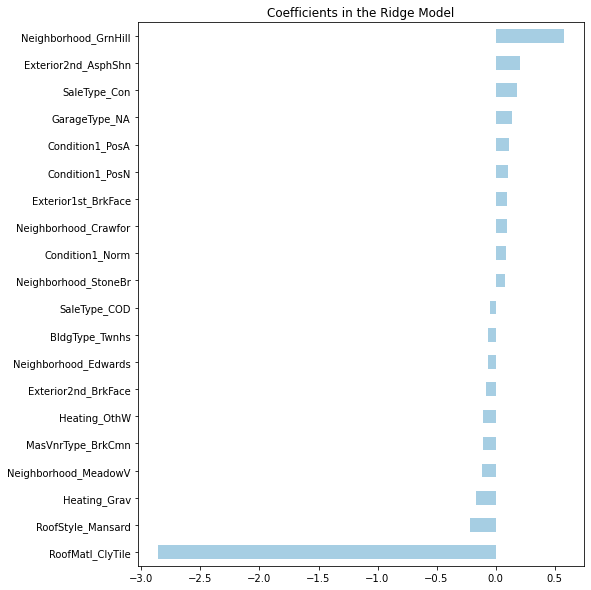

In [78]:
imp_coef = pd.concat([ridge_coef.sort_values().head(10),
 ridge_coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh')
plt.title('Coefficients in the Ridge Model');

### Lasso Model

In [79]:
#Create Lasso model
lasso = Lasso()
lasso.fit(X_train, y_train)
print('Lasso train score',lasso.score(X_train, y_train))
lasso_p = lasso.predict(X_val)
print('Lasso valuation score', lasso.score(X_val, y_val))
print('Lasso RMSE : ', np.sqrt(mean_squared_error(y_val,lasso_p)))

Lasso train score 0.757721216955713
Lasso valuation score 0.7308849974649837
Lasso RMSE :  0.21707921329886987


In [80]:
#Find optimal Lasso alpha
#create the model
lassoCV_model = LassoCV(alphas=[0.05, 0.01, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],cv=10)
#implement it on training data
lassoCV_model.fit(X_train, y_train)
optimal_lasso_alpha = lassoCV_model.alpha_
print(optimal_lasso_alpha)

0.01


In [81]:
#Recreate Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
print('Lasso train score',lasso.score(X_train, y_train))
lasso_p = lasso.predict(X_val)
print('Lasso valuation score', lasso.score(X_val, y_val))
print('Lasso RMSE : ', np.sqrt(mean_squared_error(y_val,lasso_p)))

Lasso train score 0.862536904745441
Lasso valuation score 0.8261932991458015
Lasso RMSE :  0.1744546469897546


In [82]:
lasso_coef = pd.Series(lasso.coef_, index = X_train.columns)
print('Lasso picked ' + str(sum(lasso_coef != 0)) + 
      ' features and eliminated the other ' + str(sum(lasso_coef == 0)) + ' features')

Lasso picked 19 features and eliminated the other 86 features


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

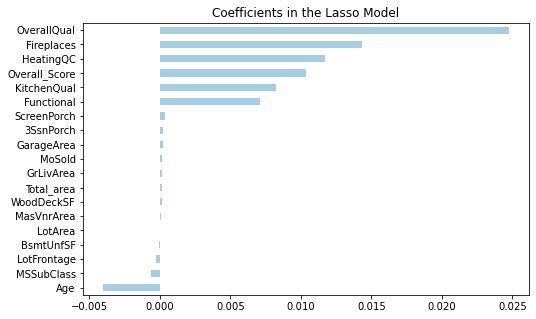

In [83]:
imp_coef2 = lasso_coef[lasso_coef!=0].sort_values()
plt.rcParams['figure.figsize'] = (8.0, 5.0)
imp_coef2.plot(kind = 'barh')
plt.title('Coefficients in the Lasso Model')

## Test file Price Prediction & Data Export

In [84]:
y_test = lasso.predict(X_test)

In [85]:
#Export prediction to submission file; must use np.exp to convert SalePrice to normal $ value
prediction_proper = pd.concat([test['Id'].reset_index(), pd.Series(np.exp(y_test.ravel()).astype(int), name = 'SalePrice')], axis = 1)
prediction_proper = prediction_proper.drop("index", axis = 1)
prediction_proper
prediction_proper.to_csv("../IOD_P1/submission.csv", index = None)